In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import hashlib
from scipy import stats

In [2]:
connection = { } # coonection parametres

### A/B test results


In [3]:
q = """
""" #extaracting users by groups and target metrics

df_t = ph.read_clickhouse(q, connection=connection)
metric_name="CTR" # target metric

In [4]:
print('Mean {metric_name} of control group: '+str(df_t[df_t.exp_group==1].ctr.mean())+ ' \n Mean {metric_name} of control group: '+str(df_t[df_t.exp_group==2].ctr.mean()))

Средний СTR контрольной группы: 0.21560459841296287 
Средний CTR тестовой группы: 0.21441927347479375


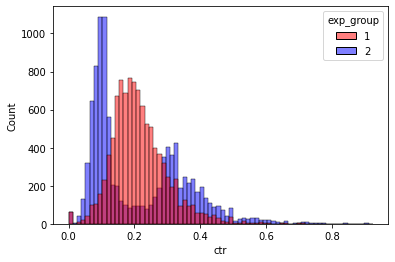

In [5]:
groups = sns.histplot(data = df_t, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

#### Using smoothing of CTR

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ctr'>

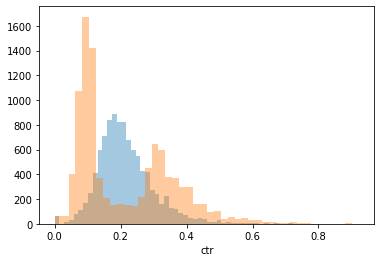

In [6]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = df_t[df_t.exp_group == 1].likes.sum()/df_t[df_t.exp_group == 1].views.sum()
global_ctr_2 = df_t[df_t.exp_group == 2].likes.sum()/df_t[df_t.exp_group == 2].views.sum()

group1 = df_t[df_t.exp_group == 1].copy()
group2 = df_t[df_t.exp_group == 2].copy()
sns.distplot(group1.ctr, 
             kde = False)
sns.distplot(group2.ctr, 
             kde = False)

#### Using mann-whitney test

In [7]:
stats.mannwhitneyu(df_t[df_t.exp_group == 1].ctr, 
                   df_t[df_t.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

#### Using Bootstrap

In [8]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

<AxesSubplot:ylabel='Count'>

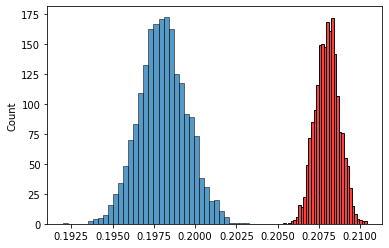

In [9]:
likes1 = df_t[df_t.exp_group == 1].likes.to_numpy()
views1 = df_t[df_t.exp_group == 1].views.to_numpy()
likes2 = df_t[df_t.exp_group == 2].likes.to_numpy()
views2 = df_t[df_t.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1, color='red')
sns.histplot(ctr2)

### Using sample transformation

In [10]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-12-02' and '2022-12-08'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_t2 = ph.read_clickhouse(q, connection=connection)

#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df_t2[df_t2.exp_group == 1].bucket_ctr, 
                   df_t2[df_t2.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

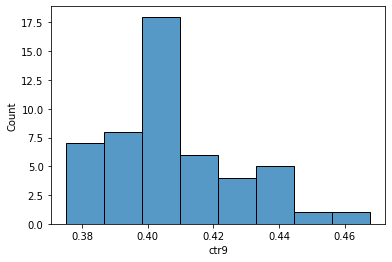

In [11]:
sns.histplot(df_t2[df_t2.exp_group == 2].ctr9)

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

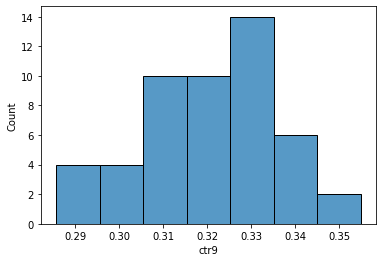

In [12]:
sns.histplot(df_t2[df_t2.exp_group == 1].ctr9)

### Exprimentation in time series

In [13]:
q2 = """
SELECT exp_group,
    toDate(time),
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-12-02' and '2022-12-08'
    and exp_group in (1,2)
GROUP BY toDate(time), exp_group
"""

df_t1 = ph.read_clickhouse(q2, connection=connection)
df_t1.head()

,exp_group,toDate(time),likes,views,ctr
0,1,2022-12-05,19057,90118,0.211467
1,1,2022-12-06,22425,108708,0.206287
2,1,2022-12-07,24024,115758,0.207536
3,1,2022-12-04,15646,74009,0.211407
4,1,2022-12-08,23737,115958,0.204703


<AxesSubplot:xlabel='toDate(time)', ylabel='ctr'>

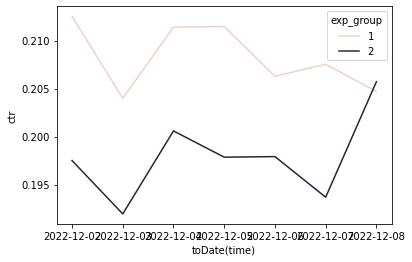

In [14]:
sns.lineplot(data=df_t1, x="toDate(time)", y="ctr", hue="exp_group")

In [15]:
q2 = """
SELECT exp_group,
    toDate(time),
    user_id,
    gender,
    max(os) as os,
    max(age) as age,
    max(country) as country,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-12-02' and '2022-12-08'
    and exp_group in (1,2)
GROUP BY toDate(time), exp_group, user_id, gender
"""
df_t3 = ph.read_clickhouse(q2, connection=connection)
df_t3.head()

,exp_group,toDate(time),user_id,gender,os,age,country,likes,views,ctr
0,2,2022-12-05,109408,1,iOS,17,Russia,5,45,0.111111
1,2,2022-12-08,135357,1,iOS,28,Russia,12,54,0.222222
2,2,2022-12-04,11043,0,Android,18,Russia,0,14,0.000000
3,2,2022-12-06,128116,0,Android,49,Azerbaijan,20,45,0.444444
4,2,2022-12-02,26222,0,iOS,27,Russia,12,31,0.387097


### Looking for distribution by sex

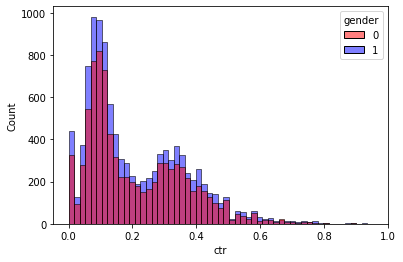

In [16]:
groups = sns.histplot(data = df_t3[df_t3.exp_group==2], 
              x='ctr', 
              hue='gender', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

### Looking for distribution by OS

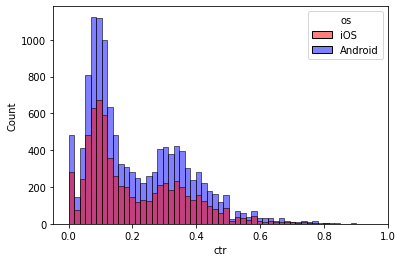

In [17]:
groups = sns.histplot(data = df_t3[df_t3.exp_group==2], 
              x='ctr', 
              hue='os', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

### Looking for distribution by age

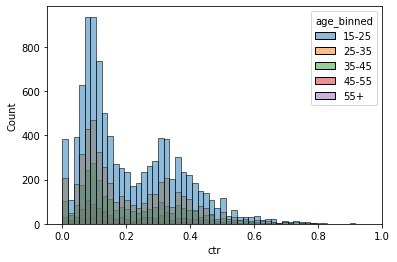

In [18]:
bins=[15,25,35,45,55,100]
labels=['15-25','25-35','35-45','45-55','55+']
df_t3['age_binned']=pd.cut(df_t3.age, bins=bins, labels=labels)
groups = sns.histplot(data = df_t3[df_t3.exp_group==2], 
              x='ctr', 
              hue='age_binned', 
              alpha=0.5,
              kde=False)

### Looking for distribution by country

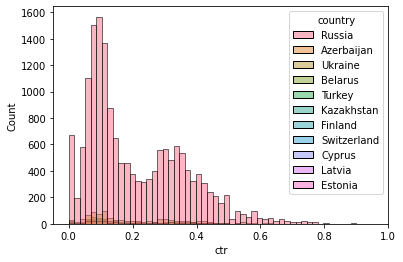

In [19]:
groups = sns.histplot(data = df_t3[df_t3.exp_group==2], 
              x='ctr', 
              hue='country', 
              alpha=0.5,
              kde=False)